# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off Speed RHP](#Off-Speed-RHP)
    - [Off Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv2022.csv', index_col = [0])
tu = pd.read_csv('../data/season23.csv')
tu = tu.loc[tu['PitcherTeam'] == 'TUS_PIO']
tu = tu[['Pitcher', 'PitcherThrows', 'TaggedPitchType', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 
         'RelSide', 'RelHeight', 'Extension']]
tu['TaggedPitchType'].replace(['Fastball'], 'Four-Seam', inplace = True)
tu['TaggedPitchType'].replace(['FourSeamFastBall'], 'Four-Seam', inplace = True)
tu['TaggedPitchType'].replace(['TwoSeamFastBall'], 'Four-Seam', inplace = True)
tu.dropna(inplace=True)
pd.set_option('max_columns', None)
#data.dropna(inplace = True)
print(data.shape)
data.head()

(682572, 65)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,pitch_type2,arm_angle,slot,whiff,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_rel_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_rel_outs_scale,woba,wraa_change,rv
0,"Zastryzny, Rob",L,FF,93.5,2451.0,167.0,-3.36,17.40,26.213904,94.6,-1.70,5.95,6.6,53.88,0.76,3.38,S,2,2,2-2,L,NaN,strike,field_out,NaN,NaN,NaN,0.0,1.0,NaN,78.0,6.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,1,1,0.0,0.0,0.0,0.11,-0.11,0.00,-0.11,-0.27,0.001,1.209,-0.326,0.001,0.269,-0.184,-0.110
1,"Zastryzny, Rob",L,CU,80.9,2266.0,273.0,13.44,-0.96,28.009889,81.1,-2.06,5.59,6.5,53.95,0.66,0.49,B,1,2,1-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,5.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,CU,35.2,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,0.032,0.032
2,"Zastryzny, Rob",L,FF,92.3,2321.0,157.0,-3.36,18.96,25.146262,92.8,-1.65,5.93,6.7,53.84,0.20,3.12,S,1,2,1-2,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,4.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,-0.152,-0.152
3,"Zastryzny, Rob",L,FF,94.3,2391.0,159.0,-4.80,17.28,25.355249,94.4,-1.65,5.93,6.4,54.09,-0.53,3.69,B,0,2,0-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,3.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.197,0.017,0.017
4,"Zastryzny, Rob",L,FF,93.4,2446.0,156.0,-3.60,18.00,26.188437,93.3,-1.81,5.93,6.4,54.13,0.62,2.19,S,0,1,0-1,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,2.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.265,-0.047,-0.047


In [3]:
tu.head()

,Pitcher,PitcherThrows,TaggedPitchType,RelSpeed,InducedVertBreak,HorzBreak,RelSide,RelHeight,Extension
0,"Salyards, Brady",Right,Four-Seam,87.3,12.7,16.7,2.3,5.8,6.3
1,"Salyards, Brady",Right,Four-Seam,86.4,17.6,13.3,2.2,5.7,6.3
2,"Salyards, Brady",Right,Slider,79.7,5.2,-4.7,2.0,5.8,6.1
3,"Salyards, Brady",Right,Slider,80.7,8.1,-5.8,2.1,5.8,5.9
4,"Salyards, Brady",Right,Four-Seam,87.5,14.1,14.0,2.3,5.6,6.4


# Features

**Independent Variables:** Velocity, HB, VB, Release Side, Release Height, Release Extension

**Dependent Variable:** Run Value

### Multicolinearity - VIF

In [4]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'pfx_x', 'pfx_z', 
                 'release_pos_x', 'release_pos_z', 'release_extension', 'rv']]

features_tu = tu[['Pitcher', 'PitcherThrows', 'TaggedPitchType', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 
                 'RelSide', 'RelHeight', 'Extension']]

#features_vif = features.select_dtypes([np.number])
#vif_data = pd.DataFrame()
#vif_data["feature"] = features_vif.columns
#
#vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
#                   for i in range(len(features_vif.columns))]
#
#print(vif_data.sort_values(by = 'VIF'))

In [5]:
fb = features[features['pitch_type'].isin(['FF', 'SI'])]
bb = features[features['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fb = fb.loc[fb['p_throws'] == 'R']
lhp_fb = fb.loc[fb['p_throws'] == 'L']
rhp_bb = bb.loc[bb['p_throws'] == 'R']
lhp_bb = bb.loc[bb['p_throws'] == 'L']
rhp_os = os.loc[os['p_throws'] == 'R']
lhp_os = os.loc[os['p_throws'] == 'L']

fb_tu = features_tu[features_tu['TaggedPitchType'].isin(['Four-Seam'])]
bb_tu = features_tu[features_tu['TaggedPitchType'].isin(['Slider', 'Cutter', 'Curveball'])]
os_tu = features_tu[features_tu['TaggedPitchType'].isin(['ChangeUp', 'Splitter'])]
rhp_tu = features_tu.loc[features_tu['PitcherThrows'] == 'R']
lhp_tu = features_tu.loc[features_tu['PitcherThrows'] == 'L']
rhp_fb_tu = fb_tu.loc[fb_tu['PitcherThrows'] == 'Right']
lhp_fb_tu = fb_tu.loc[fb_tu['PitcherThrows'] == 'Left']
rhp_bb_tu = bb_tu.loc[bb_tu['PitcherThrows'] == 'Right']
lhp_bb_tu = bb_tu.loc[bb_tu['PitcherThrows'] == 'Left']
rhp_os_tu = os_tu.loc[os_tu['PitcherThrows'] == 'Right']
lhp_os_tu = os_tu.loc[os_tu['PitcherThrows'] == 'Left']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Sinker

In [6]:
print('Baseline RHP Fastball RunValue Accuracy Score:', round(rhp_fb.rv.mean(), 2))

Baseline RHP Fastball RunValue Accuracy Score: -0.01


In [7]:
features_fb_r = rhp_fb.select_dtypes([np.number])
X = features_fb_r.drop(columns = ['rv'])
y = features_fb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_fb_r = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_fb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_r), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.254
Test MAE: 0.131
Cross Val Score: [0.0004304  0.0004494  0.00084627 0.00120621 0.00082103]
Cross Val Score: 0.001 

R2 Score: 0.001
RMSE: 0.255
MAE: 0.131


- Average RHP FB Run Value prediction error is .26 runs

In [8]:
features_fb_r_tu = rhp_fb_tu.select_dtypes([np.number])
#features_fb_r_tu.dropna(inplace=True)
X_tu = features_fb_r_tu
pred_tu = lr.predict(X_tu)

In [9]:
pred_tu.shape

(2450,)

In [31]:
rhp_fb_tu['n_pitches'] = 1
rhp_fb_tu['xRV'] = pred_tu
rhp_fb_tu['xRV/100'] = round(((rhp_fb_tu['xRV'] / (rhp_fb_tu['n_pitches'])) * 100), 2)

rhp_fb_tu['Stuff+'] = (100 * (-rhp_fb_tu['xRV/100'] / -rhp_fb_tu['xRV/100'].mean()))
#rhp_fb.head()

grouped_fb_r_tu = rhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                              as_index = False)['n_pitches', 'xRV'].sum()

avg_fb_r_tu = rhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'RelSide', 'RelHeight', 
                                            'Extension', 'Stuff+'].mean()
fbr_stuff_tu = pd.merge(avg_fb_r_tu, grouped_fb_r_tu, how = 'left', 
                        on = ['Pitcher', 'PitcherThrows', 'TaggedPitchType'])

#fbr_stuff_tu['xRV/100'] = round(((fbr_stuff_tu['xRV'] / (fbr_stuff_tu['n_pitches'])) * 100), 2)
#fbr_stuff_tu = fbr_stuff.loc[fbr_stuff['n_pitches'] >= 100]
fbr_stuff_tu = fbr_stuff_tu.round(1)
fbr_stuff_tu.insert(3, 'n_pitches', fbr_stuff_tu.pop('n_pitches'))
#fbr_stuff_tu.sort_values(by = 'xRV', ascending = False).head(10)
#fbr_stuff_tu.head(10)
#print(fbr_stuff_tu.to_markdown())

|    | Pitcher              | PitcherThrows   | TaggedPitchType   |   n_pitches |   RelSpeed |   HorzBreak |   InducedVertBreak |   RelSide |   RelHeight |   Extension |   Stuff+ |   xRV |
|---:|:---------------------|:----------------|:------------------|------------:|-----------:|------------:|-------------------:|----------:|------------:|------------:|---------:|------:|
|  0 | Absher, Luke         | Right           | Four-Seam         |         455 |       85.5 |        10   |               16.6 |       1.5 |         5.8 |         6.6 |     92.4 |   7.2 |
|  1 | Bonilla, Sam         | Right           | Four-Seam         |          80 |       87   |         6.4 |               14.9 |       2.1 |         5.8 |         6.6 |     88.4 |   1.2 |
|  2 | Fox Birdwell, Trejen | Right           | Four-Seam         |         273 |       87   |         9.6 |               13   |       3.1 |         5.8 |         5.8 |     70   |   3.3 |
|  3 | Nelson, Jonathan     | Right           | Four-Seam         |         156 |       85.1 |        12.6 |               16   |       0.8 |         5.3 |         6.1 |     66.1 |   1.8 |
|  4 | Ponder, Kohen        | Right           | Four-Seam         |          38 |       84.4 |         9.3 |               11.6 |       1.5 |         5.4 |         5.6 |     95.8 |   0.6 |
|  5 | Quinn, Billy         | Right           | Four-Seam         |         297 |       85.6 |        12   |               11.4 |       1.6 |         6.3 |         6.4 |     96.9 |   4.9 |
|  6 | Salyards, Brady      | Right           | Four-Seam         |         328 |       87   |        11   |               19.7 |       2   |         5.7 |         6.6 |     68.2 |   3.8 |
|  7 | Sliwinski, Drew      | Right           | Four-Seam         |         170 |       84.1 |         4.8 |               15.8 |       1.6 |         6   |         6.4 |    148.5 |   4.3 |
|  8 | White, Tyler         | Right           | Four-Seam         |          89 |       81.6 |         4.5 |               14.2 |       0.5 |         6.4 |         6.6 |    203.2 |   3.1 |
|  9 | Willett, Jacob       | Right           | Four-Seam         |         166 |       86.4 |         6   |               20.5 |       1   |         6.1 |         6.5 |    123   |   3.5 |
| 10 | Willis, Seth         | Right           | Four-Seam         |         398 |       86.4 |        11.5 |               20.4 |       0.6 |         6.5 |         5.4 |    120.6 |   8.2 |

### RHP Fastball xRV by HB & VB

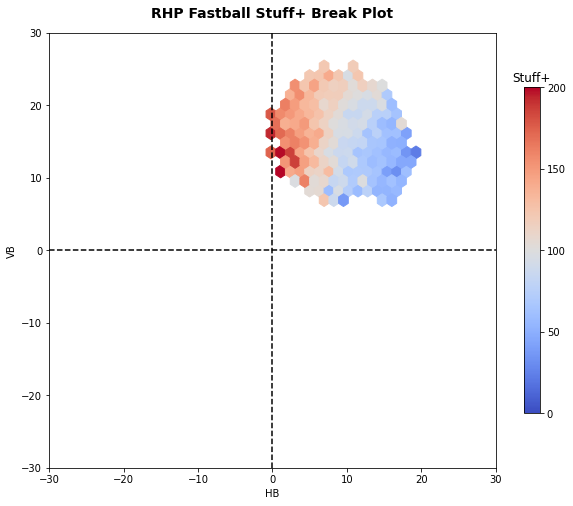

In [33]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_fb_tu['HorzBreak'], rhp_fb_tu['InducedVertBreak'], C = rhp_fb_tu['Stuff+'], cmap = 'coolwarm', 
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Stuff+ Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
#print('RHP Fastball Avg Stuff+:', round(rhp_fb['Stuff+'].mean(), 2))

## Fastball LHP Grouped

#### 4-Seam, Sinker

In [34]:
print('Baseline LHP Fastball RunValue Accuracy Score:', round(lhp_fb.rv.mean(), 2))

Baseline LHP Fastball RunValue Accuracy Score: -0.01


In [35]:
features_fb_l = lhp_fb.select_dtypes([np.number])
X = features_fb_l.drop(columns = ['rv'])
y = features_fb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_fb_l = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_fb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_l), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.254
Test MAE: 0.13
Cross Val Score: [ 8.28537067e-04  3.84167253e-04 -9.28805082e-04  8.56752915e-05
  7.42803280e-04]
Cross Val Score: 0.0 

R2 Score: 0.001
RMSE: 0.253
MAE: 0.13


In [36]:
features_fb_l_tu = lhp_fb_tu.select_dtypes([np.number])
#features_fb_l_tu.dropna(inplace=True)
X_tu = features_fb_l_tu
pred_tu = lr.predict(X_tu)

- Average LHP FB Run Value prediction error is .26 runs

### LHP Fastball Actual & Predicted Values

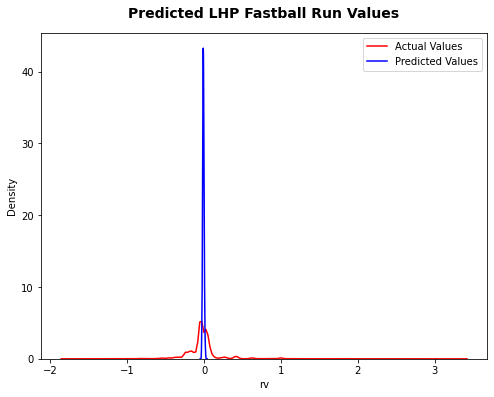

In [37]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV Table

In [13]:
lhp_fb['n_pitches'] = 1
lhp_fb['xRV'] = pred
lhp_fb['RV/100'] = round(((lhp_fb['rv'] / (lhp_fb['n_pitches'])) * 100), 2)
lhp_fb['xRV/100'] = round(((lhp_fb['xRV'] / (lhp_fb['n_pitches'])) * 100), 2)
lhp_fb['Stuff+'] = 100 * (-lhp_fb['xRV/100'] / -lhp_fb['xRV/100'].mean())

grouped_fb_l = lhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV'].sum()

avg_fb_l = lhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z',
                                            'release_extension', 'Stuff+'].mean()
fb_l_rv_table = pd.merge(avg_fb_l, grouped_fb_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

fb_l_rv_table['RV/100'] = round(((fb_l_rv_table['rv'] / (fb_l_rv_table['n_pitches'])) * 100), 2)
fb_l_rv_table['xRV/100'] = round(((fb_l_rv_table['xRV'] / (fb_l_rv_table['n_pitches'])) * 100), 2)

fb_l_rv_table.insert(3, 'n_pitches', fb_l_rv_table.pop('n_pitches'))
fb_l_rv_table = fb_l_rv_table.round(1)
print(fb_l_rv_table.shape)
fb_l_rv_table.head()

(326, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+,rv,xRV,RV/100,xRV/100
0,"Akin, Keegan",L,FF,597,93.6,-10.8,17.9,-2.2,6.1,5.8,201.2,-20.3,-10.1,-3.4,-1.7
1,"Alexander, Scott",L,SI,152,92.2,-13.7,4.4,-1.8,5.8,6.1,-4.4,-7.9,0.1,-5.2,0.0
2,"Alexander, Tyler",L,FF,353,90.0,-7.7,17.9,-1.9,5.8,6.3,43.5,-4.0,-1.3,-1.1,-0.4
3,"Alexander, Tyler",L,SI,273,90.1,-14.6,12.8,-1.9,5.7,6.3,-28.6,3.7,0.7,1.4,0.2
4,"Allard, Kolby",L,FF,130,91.2,-7.3,18.2,-1.9,5.4,6.2,115.0,-0.9,-1.3,-0.7,-1.0


### LHP Fastball xRV by HB & VB

LHP Fastball Avg Stuff+: 100.0


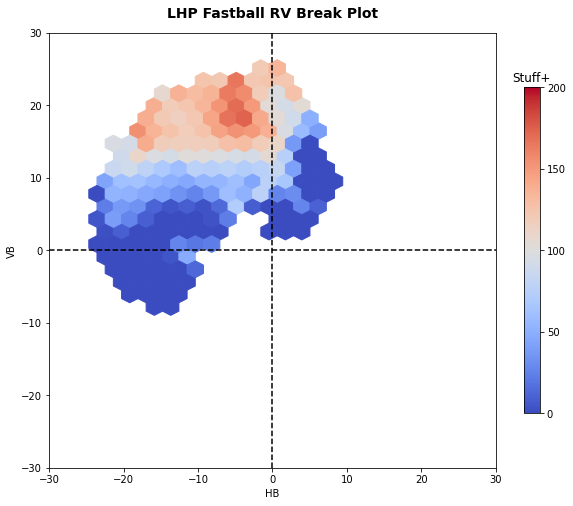

In [14]:
plt.figure(figsize = (10, 8))
plt.hexbin(lhp_fb['pfx_x'], lhp_fb['pfx_z'], C = lhp_fb['Stuff+'], cmap = 'coolwarm',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Fastball Avg Stuff+:', round(lhp_fb['Stuff+'].mean(), 2))

## Breaking Ball RHP

#### Slider, Cutter, Curveball, Knuckle Curve

In [15]:
print('Baseline RHP Breaking Ball RunValue Accuracy Score:', round(rhp_bb.rv.mean(), 2))

Baseline RHP Breaking Ball RunValue Accuracy Score: -0.02


In [16]:
rhp_bb.dropna(inplace = True)
features_bb_r = rhp_bb.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_bb_r = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.246
Test MAE: 0.125
Cross Val Score: [1.03171913e-03 1.05936146e-05 1.06687632e-03 1.45397342e-04
 4.77186923e-04]
Cross Val Score: 0.001 

R2 Score: 0.001
RMSE: 0.248
MAE: 0.126


- Average RHP Breaking Ball Run Value prediction error is .26 runs

### RHP Breaking Ball Actual & Predicted Values

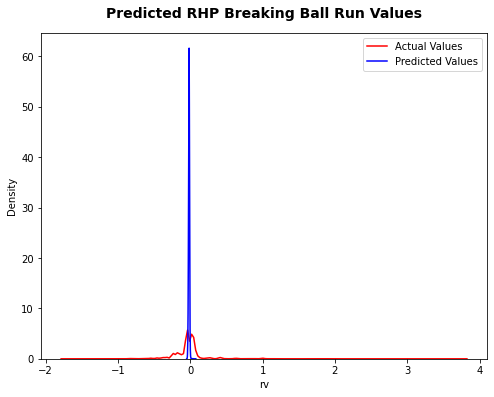

In [17]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball RV Table

In [18]:
rhp_bb['n_pitches'] = 1
rhp_bb['xRV'] = pred
rhp_bb['RV/100'] = round(((rhp_bb['rv'] / (rhp_bb['n_pitches'])) * 100), 2)
rhp_bb['xRV/100'] = round(((rhp_bb['xRV'] / (rhp_bb['n_pitches'])) * 100), 2)
rhp_bb['Stuff+'] = 100 * (-rhp_bb['xRV/100'] / -rhp_bb['xRV/100'].mean())

grouped_bb_r = rhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV',].sum()

avg_bb_r = rhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
bb_r_rv_table = pd.merge(avg_bb_r, grouped_bb_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

bb_r_rv_table['RV/100'] = round(((bb_r_rv_table['rv'] / (bb_r_rv_table['n_pitches'])) * 100), 2)
bb_r_rv_table['xRV/100'] = round(((bb_r_rv_table['xRV'] / (bb_r_rv_table['n_pitches'])) * 100), 2)

bb_r_rv_table.insert(3, 'n_pitches', bb_r_rv_table.pop('n_pitches'))
bb_r_rv_table = bb_r_rv_table.round(1)
print(bb_r_rv_table.shape)
bb_r_rv_table.head()

(989, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+,rv,xRV,RV/100,xRV/100
0,"Abbott, Cory",R,KC,171,84.5,-0.7,-5.3,2.5,5.9,6.0,65.2,-1.5,-1.9,-0.9,-1.1
1,"Abbott, Cory",R,SL,210,86.7,10.5,5.9,2.5,5.9,6.1,-28.2,1.9,1.0,0.9,0.5
2,"Abreu, Albert",R,SL,201,88.7,-2.5,5.5,2.1,5.7,6.4,91.1,-5.1,-3.1,-2.5,-1.6
3,"Abreu, Bryan",R,CU,97,84.4,-11.5,-7.6,2.1,6.0,6.2,153.0,-2.2,-2.5,-2.3,-2.6
4,"Abreu, Bryan",R,SL,408,88.4,-8.2,-2.6,2.2,5.7,6.4,150.3,-15.3,-10.5,-3.8,-2.6


### RHP Breaking Ball xRV by HB & VB

RHP Breaking Ball Avg Stuff+: 100.0


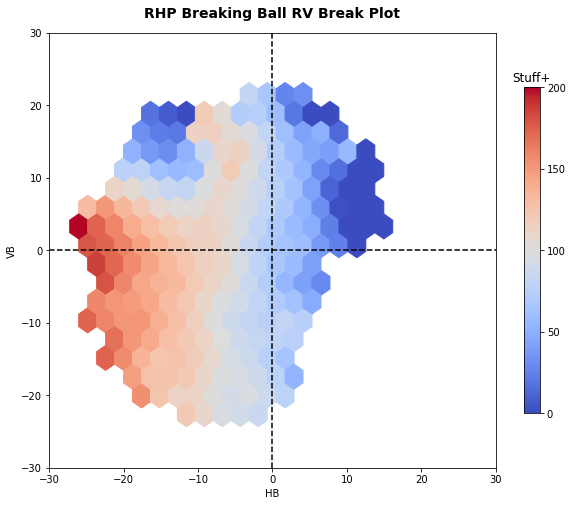

In [19]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['Stuff+'],cmap='coolwarm',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg Stuff+:', round(rhp_bb['Stuff+'].mean(), 2))

## Breaking Ball LHP
#### Slider, Cutter, Curveball, Knuckle Curve

In [20]:
print('Baseline LHP Breaking Ball RunValue Accuracy Score:', round(lhp_bb.rv.mean(), 2))

Baseline LHP Breaking Ball RunValue Accuracy Score: -0.02


In [21]:
features_bb_l = lhp_bb.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv'])
y = features_bb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_bb_l = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.246
Test MAE: 0.127
Cross Val Score: [-0.0019186  -0.000218   -0.00057317 -0.00141016  0.00105717]
Cross Val Score: -0.001 

R2 Score: 0.001
RMSE: 0.252
MAE: 0.129


- Average LHP Breaking Ball Run Value prediction error is .26 runs

### LHP Breaking Ball Actual & Predicted Values

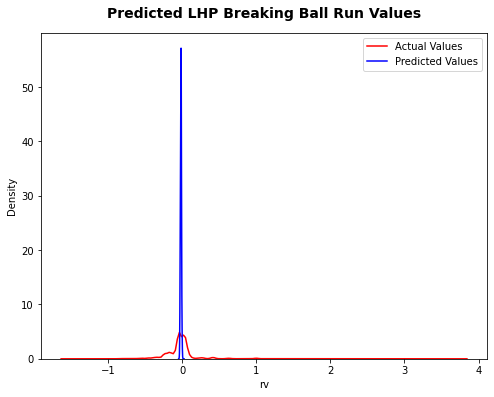

In [22]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball RV Table

In [23]:
lhp_bb['n_pitches'] = 1
lhp_bb['xRV'] = pred
lhp_bb['RV/100'] = round(((lhp_bb['rv'] / (lhp_bb['n_pitches'])) * 100), 2)
lhp_bb['xRV/100'] = round(((lhp_bb['xRV'] / (lhp_bb['n_pitches'])) * 100), 2)
lhp_bb['Stuff+'] = 100 * (-lhp_bb['xRV/100'] / -lhp_bb['xRV/100'].mean())

grouped_bb_l = lhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV'].sum()

avg_bb_l = lhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z',
                                            'release_extension', 'Stuff+'].mean()
bb_l_rv_table = pd.merge(avg_bb_l, grouped_bb_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

bb_l_rv_table['RV/100'] = round(((bb_l_rv_table['rv'] / (bb_l_rv_table['n_pitches'])) * 100), 2)
bb_l_rv_table['xRV/100'] = round(((bb_l_rv_table['xRV'] / (bb_l_rv_table['n_pitches'])) * 100), 2)

bb_l_rv_table.insert(3, 'n_pitches', bb_l_rv_table.pop('n_pitches'))
bb_l_rv_table = bb_l_rv_table.round(1)
print(bb_l_rv_table.shape)
bb_l_rv_table.head()

(343, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+,rv,xRV,RV/100,xRV/100
0,"Akin, Keegan",L,CU,5,75.1,10.4,-12.4,-2.3,5.8,6.0,129.3,-0.1,-0.1,-1.4,-2.1
1,"Akin, Keegan",L,SL,338,85.4,5.1,1.4,-2.4,5.9,5.8,116.1,-6.0,-6.3,-1.8,-1.9
2,"Alexander, Scott",L,SL,27,83.9,6.4,0.5,-1.9,5.8,6.1,105.7,-2.2,-0.5,-8.2,-1.7
3,"Alexander, Tyler",L,FC,408,85.5,3.7,9.3,-2.0,5.7,6.2,54.6,-3.2,-3.6,-0.8,-0.9
4,"Alexander, Tyler",L,SL,161,77.8,13.1,0.4,-1.9,5.8,6.2,94.9,-5.4,-2.5,-3.3,-1.5


### LHP Breaking Ball xRV by HB & VB

LHP Breaking Ball Avgerage Stuff+: 100.0


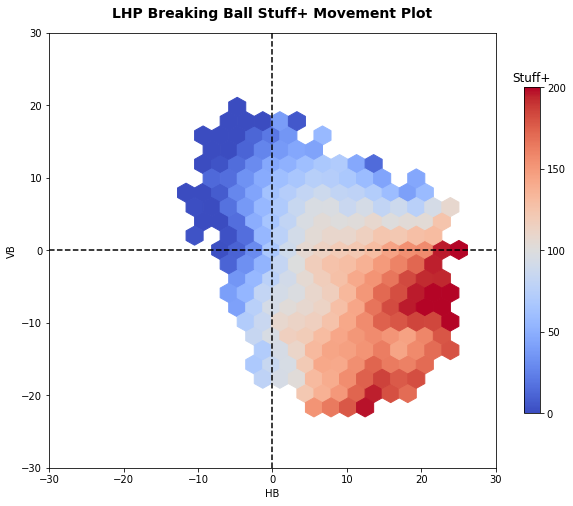

In [24]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_bb['pfx_x'], lhp_bb['pfx_z'], C = lhp_bb['Stuff+'],cmap='coolwarm', 
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Breaking Ball Avgerage Stuff+:', round(lhp_bb['Stuff+'].mean(), 2))

## Off Speed RHP

#### Changeup, Splitter

In [25]:
print('Baseline RHP Off Speed RunValue Accuracy Score:', round(rhp_os.rv.mean(), 2))

Baseline RHP Off Speed RunValue Accuracy Score: -0.02


In [26]:
features_os_r = rhp_os.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_os_r = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.0
Test RMSE: 0.258
Test MAE: 0.137
Cross Val Score: [ 0.00058021 -0.00036001 -0.00129048  0.00045615  0.00019638]
Cross Val Score: -0.0 

R2 Score: 0.001
RMSE: 0.255
MAE: 0.136


- Average RHP Off Speed Run Value prediction error is .26 runs

### RHP Off Speed Actual & Predicted Run Values

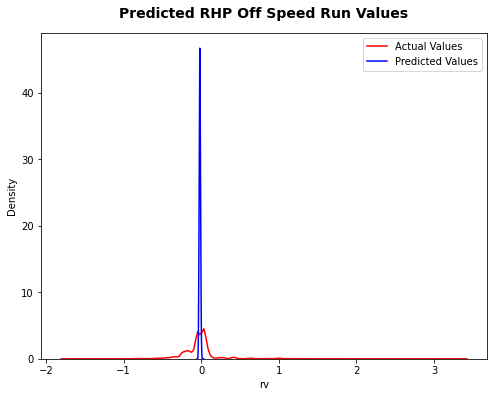

In [27]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Off Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off Speed RV Table

In [28]:
rhp_os['n_pitches'] = 1
rhp_os['xRV'] = pred
rhp_os['RV/100'] = round(((rhp_os['rv'] / (rhp_os['n_pitches'])) * 100), 2)
rhp_os['xRV/100'] = round(((rhp_os['xRV'] / (rhp_os['n_pitches'])) * 100), 2)
rhp_os['Stuff+'] = 100 * (-rhp_os['xRV/100'] / -rhp_os['xRV/100'].mean())

grouped_os_r = rhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV',].sum()

avg_os_r = rhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
os_r_rv_table = pd.merge(avg_os_r, grouped_os_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

os_r_rv_table['RV/100'] = round(((os_r_rv_table['rv'] / (os_r_rv_table['n_pitches'])) * 100), 2)
os_r_rv_table['xRV/100'] = round(((os_r_rv_table['xRV'] / (os_r_rv_table['n_pitches'])) * 100), 2)

os_r_rv_table.insert(3, 'n_pitches', os_r_rv_table.pop('n_pitches'))
os_r_rv_table = os_r_rv_table.round(1)
print(os_r_rv_table.shape)
os_r_rv_table.head()

(484, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+,rv,xRV,RV/100,xRV/100
0,"Abreu, Albert",R,CH,71,88.0,16.6,8.8,1.9,5.7,6.6,74.2,2.2,-0.9,3.2,-1.2
1,"Abreu, Bryan",R,CH,3,89.7,12.2,12.3,1.9,5.9,6.5,47.5,0.1,-0.0,4.3,-0.8
2,"Acevedo, Domingo",R,CH,218,86.8,18.1,3.3,2.0,5.5,5.9,87.3,-12.4,-3.2,-5.7,-1.5
3,"Adam, Jason",R,CH,300,90.0,16.4,2.2,1.6,6.0,6.5,177.5,-10.9,-8.9,-3.6,-3.0
4,"Adon, Joan",R,CH,80,87.4,16.1,7.4,2.7,5.9,6.4,78.6,-1.0,-1.1,-1.3,-1.3


### RHP Off Speed xRV by HB & VB

RHP Off Speed Avg Stuff+: 100.0


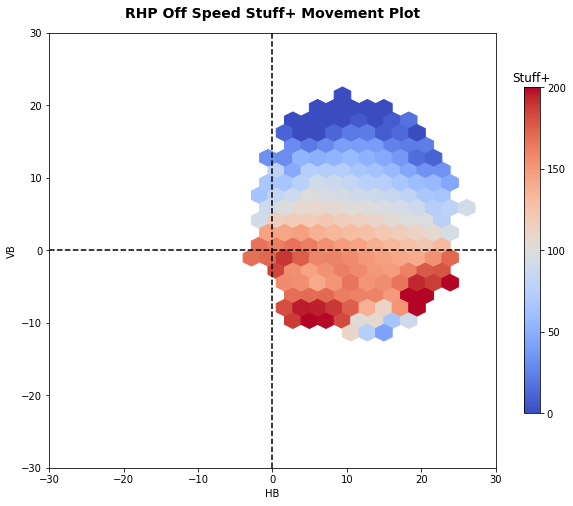

In [29]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['Stuff+'], cmap = 'coolwarm',
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off Speed Avg Stuff+:', round(rhp_os['Stuff+'].mean(), 2))

## Off Speed LHP
#### Changeup, Splitter

In [30]:
print('Baseline LHP Off Speed RunValue Accuracy Score:', round(lhp_os.rv.mean(), 2))

Baseline LHP Off Speed RunValue Accuracy Score: -0.01


In [31]:
features_os_l = lhp_os.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv'])
y = features_os_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_os_l = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.275
Test MAE: 0.142
Cross Val Score: [ 0.00022675 -0.00549067  0.00116623 -0.00410241  0.00130452]
Cross Val Score: -0.001 

R2 Score: 0.001
RMSE: 0.262
MAE: 0.138


- Average RHP Off Speed Run Value prediction error is .27 runs

### LHP Off Speed Actual & Predicted Values

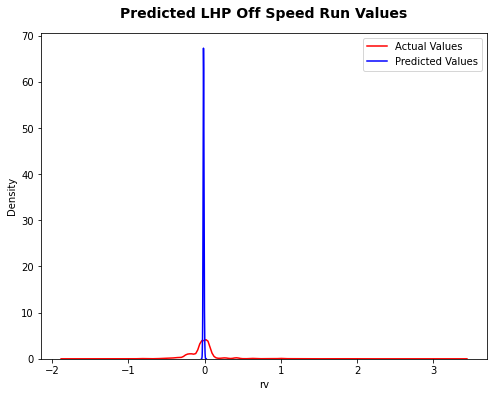

In [32]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Off Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off Speed RV Table

In [33]:
lhp_os['n_pitches'] = 1
lhp_os['xRV'] = pred
lhp_os['RV/100'] = round(((lhp_os['rv'] / (lhp_os['n_pitches'])) * 100), 2)
lhp_os['xRV/100'] = round(((lhp_os['xRV'] / (lhp_os['n_pitches'])) * 100), 2)
lhp_os['Stuff+'] = 100 * (-lhp_os['xRV/100'] / -lhp_os['xRV/100'].mean())

grouped_os_l = lhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches', 'rv', 'xRV'].sum()

avg_os_l = lhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z',
                                            'release_extension', 'Stuff+'].mean()
os_l_rv_table = pd.merge(avg_os_l, grouped_os_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])

os_l_rv_table['RV/100'] = round(((os_l_rv_table['rv'] / (os_l_rv_table['n_pitches'])) * 100), 2)
os_l_rv_table['xRV/100'] = round(((os_l_rv_table['xRV'] / (os_l_rv_table['n_pitches'])) * 100), 2)

os_l_rv_table.insert(3, 'n_pitches', os_l_rv_table.pop('n_pitches'))
os_l_rv_table = os_l_rv_table.round(1)
print(os_l_rv_table.shape)
os_l_rv_table.head()

(178, 15)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+,rv,xRV,RV/100,xRV/100
0,"Akin, Keegan",L,CH,210,84.2,-16.0,8.8,-2.3,5.8,6.0,79.8,1.1,-2.2,0.5,-1.0
1,"Alexander, Scott",L,CH,35,86.7,-14.6,3.4,-1.8,5.7,6.2,112.6,-1.1,-0.5,-3.2,-1.5
2,"Alexander, Tyler",L,CH,273,82.8,-13.7,8.3,-1.9,5.7,6.3,88.0,5.1,-3.1,1.9,-1.1
3,"Allard, Kolby",L,CH,42,82.3,-13.1,11.7,-2.1,5.5,5.7,25.3,1.3,-0.1,3.0,-0.3
4,"Alldred, Cam",L,CH,2,81.2,-9.1,0.5,-3.4,5.2,6.4,40.4,0.1,-0.0,3.2,-0.5


### LHP Off Speed xRV by HB & VB

LHP Off Speed Avg Stuff+: 100.0


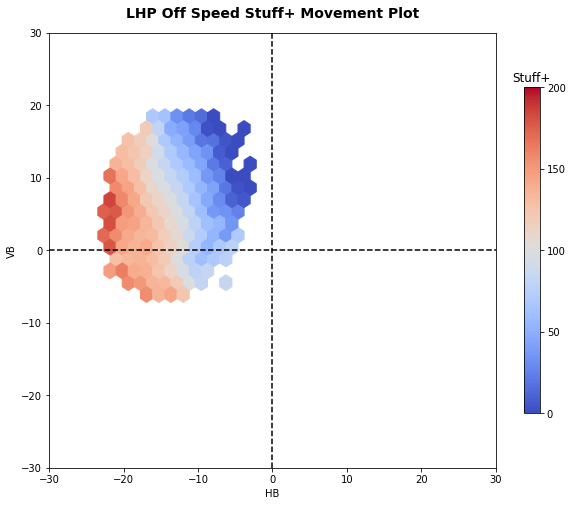

In [34]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_os['pfx_x'], lhp_os['pfx_z'], C = lhp_os['Stuff+'], cmap = 'coolwarm',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Off Speed Avg Stuff+:', round(lhp_os['Stuff+'].mean(), 2))

## Save Grouped RV Tables to CSV

In [35]:
xrv_grouped = pd.concat([rhp_fb, lhp_fb, rhp_bb, lhp_bb, rhp_os, lhp_os], ignore_index = True)
xrv_grouped.fillna(0, inplace = True)
xrv_grouped.to_csv('../data/xrv_grouped.csv')

rv_table = pd.concat([fb_r_rv_table, fb_l_rv_table, bb_r_rv_table, bb_l_rv_table, os_r_rv_table, os_l_rv_table])
rv_table.to_csv('../data/rv_table.csv')